In [1]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [2]:
from torch.nn.functional import relu
from copy import deepcopy


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()




def perturb_acts(model, linear_activations, mu, sigma):
    mean = torch.full_like(linear_activations, mu)
    var = torch.full_like(linear_activations, sigma)
    
    acts = deepcopy(relu(linear_activations + torch.normal(mean, var)))

    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()


def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).mean()


def full_ablations(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    
    perturbed_loss001 =  perturb_acts(model, linear_acts, 0.0, 0.1)
    perturbed_loss01 = perturb_acts(model, linear_acts, 0.0, 1.0)
    perturbed_loss11 = perturb_acts(model, linear_acts, 1.0, 1.0)
    perturbed_lossneg11 = perturb_acts(model, linear_acts, -1.0, 1.0)
    
    abs_logits = model.unembed(linear_acts.abs())
    abs_loss = loss_fn(abs_logits, targets).mean()
    
    full_sign_logits = model.unembed(relu(-1. * linear_acts))
    full_sign_loss = loss_fn(full_sign_logits, targets).mean()
    
    fmodel, params = functorch.make_functional(model)
    
    fparams = [deepcopy(p) for p in params]
    fparams[0] = -1.0 * params[0]
    
    left_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    fparams = [deepcopy(p) for p in params]
    fparams[1] = -1.0 * params[1]
    
    right_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    return {
        'model_seed': model_seed,
        'original_loss': original_loss.item(),
        'full_sign_loss': full_sign_loss.item(),
        'abs_loss': abs_loss.item(),
        'left_sign_loss':  left_sign_loss.item(),
        'right_sign_loss': right_sign_loss.item(),
        'perturbed_loss_mean0_var1': perturbed_loss01.item(),
        'perturbed_loss_mean0_var0.1': perturbed_loss001.item(),
        'perturbed_loss_mean1_var1': perturbed_loss11.item(),
        'perturbed_loss_mean-1_var1': perturbed_lossneg11.item(),
    }



def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')
    



In [3]:
import json

with open('../s6_subgroups.json') as jfile:
    all_s6_subgroups = json.load(jfile)

In [4]:
def tuplefy(generators):
    return [tuple(g) for g in generators]

for k, v in all_s6_subgroups.items():
    v['generators'] = [tuplefy(gens) for gens in v['generators']]

In [5]:
import math

def make_indicator_fn(subgroup, full_group):
    f = torch.zeros((len(full_group), 2))
    inval = 1 - ((len(subgroup) * 1.0) / len(full_group))
    notinval = ((len(subgroup) * -1.0) / len(full_group))
                 
    for i, g in enumerate(full_group):
        if g.sigma in subgroup:
            f[i, 0] = inval
        else:
            f[i, 0] = notinval
       
    return f
    
    

In [6]:
full_group = Permutation.full_group(6)

for k, v in all_s6_subgroups.items():
    f = torch.zeros((720, 2))
    gens = v['generators'][0]
    sg = generate_subgroup(gens)
    f = make_indicator_fn(sg, full_group)
    total_power = (f ** 2).mean(dim=0)
    fft = slow_sn_ft_1d(f, 6)
    power = calc_power(fft, 720)
    power = {i: p / total_power for i, p in power.items()}
    print(k)
    for irrep, p in power.items():
        print(f'\t{irrep}: {p[0].item():.4f}')
    

C2_transposition
	(1, 1, 1, 1, 1, 1): 0.0000
	(2, 1, 1, 1, 1): 0.0139
	(2, 2, 1, 1): 0.0752
	(2, 2, 2): 0.0279
	(3, 1, 1, 1): 0.1114
	(3, 2, 1): 0.3565
	(3, 3): 0.0418
	(4, 1, 1): 0.1671
	(4, 2): 0.1504
	(5, 1): 0.0557
	(6,): 0.0000
C2_triple_transposition
	(1, 1, 1, 1, 1, 1): 0.0000
	(2, 1, 1, 1, 1): 0.0418
	(2, 2, 1, 1): 0.0752
	(2, 2, 2): 0.0557
	(3, 1, 1, 1): 0.1671
	(3, 2, 1): 0.3565
	(3, 3): 0.0139
	(4, 1, 1): 0.1114
	(4, 2): 0.1504
	(5, 1): 0.0279
	(6,): 0.0000
C2_double_transposition
	(1, 1, 1, 1, 1, 1): 0.0028
	(2, 1, 1, 1, 1): 0.0418
	(2, 2, 1, 1): 0.1253
	(2, 2, 2): 0.0418
	(3, 1, 1, 1): 0.1114
	(3, 2, 1): 0.3565
	(3, 3): 0.0418
	(4, 1, 1): 0.1114
	(4, 2): 0.1253
	(5, 1): 0.0418
	(6,): 0.0000
C3_three_cycle
	(1, 1, 1, 1, 1, 1): 0.0042
	(2, 1, 1, 1, 1): 0.0628
	(2, 2, 1, 1): 0.1130
	(2, 2, 2): 0.0209
	(3, 1, 1, 1): 0.1674
	(3, 2, 1): 0.2678
	(3, 3): 0.0209
	(4, 1, 1): 0.1674
	(4, 2): 0.1130
	(5, 1): 0.0628
	(6,): 0.0000
C3_double_three_cycle
	(1, 1, 1, 1, 1, 1): 0.0042
	(2, 1

In [7]:
ckpt_dir = Path('/mnt/ssd-1/dashiell/sn_checkpoints/')
model_seed = 0
run_name = f's6_50_{model_seed}'
#run_name = Path('s5_lr1e-5_5')

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cuda:0'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

#out, cache = model.run_with_cache(lperms, rperms)
#loss = loss_fn(out, targets)

#linear_acts = cache['hook_linear']

<All keys matched successfully>

In [8]:
cache = []

for lp, rp in zip(lperms.split(14400), rperms.split(14400)):
    _, _cache = model.run_with_cache(lp, rp)
    cache.append(_cache['hook_linear'].to('cpu'))
    

In [9]:
linear_preacts = torch.concat(cache, dim=0)
linear_preacts.shape

torch.Size([518400, 1024])

In [10]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    tensor_dim = tensor.shape[1]
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(tensor_dim)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


W = model.linear.weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :512].T, 6)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 512:].T, 6)

In [11]:
lpower_df.melt(id_vars='irrep').sort(['variable', 'value']).groupby('variable').tail(1).groupby('irrep').count()

irrep,count
str,u32
"""(2, 2, 1, 1)""",20
"""(5, 1)""",318
"""(4, 2)""",12
"""(2, 1, 1, 1, 1…",117
"""(2, 2, 2)""",165
"""(3, 3)""",368
"""(6,)""",8
"""(3, 1, 1, 1)""",4
"""(4, 1, 1)""",12


In [12]:
(model.lembed.weight @ W[:, :512].T).detach().numpy().shape

(720, 1024)

In [12]:
S6_df = pl.DataFrame({'perms': [str(p) for p in full_group]})

left_preact_df = pl.concat(
    [
        S6_df,
        pl.DataFrame((model.lembed.weight @ W[:, :512].T).detach().numpy(), schema=[f'dim{i}' for i in range(1024)])
    ],
    how='horizontal'
)

right_preact_df = pl.concat(
    [
        S6_df,
        pl.DataFrame((model.lembed.weight @ W[:, 512:].T).detach().numpy(), schema=[f'dim{i}' for i in range(1024)])
    ],
    how='horizontal'
)

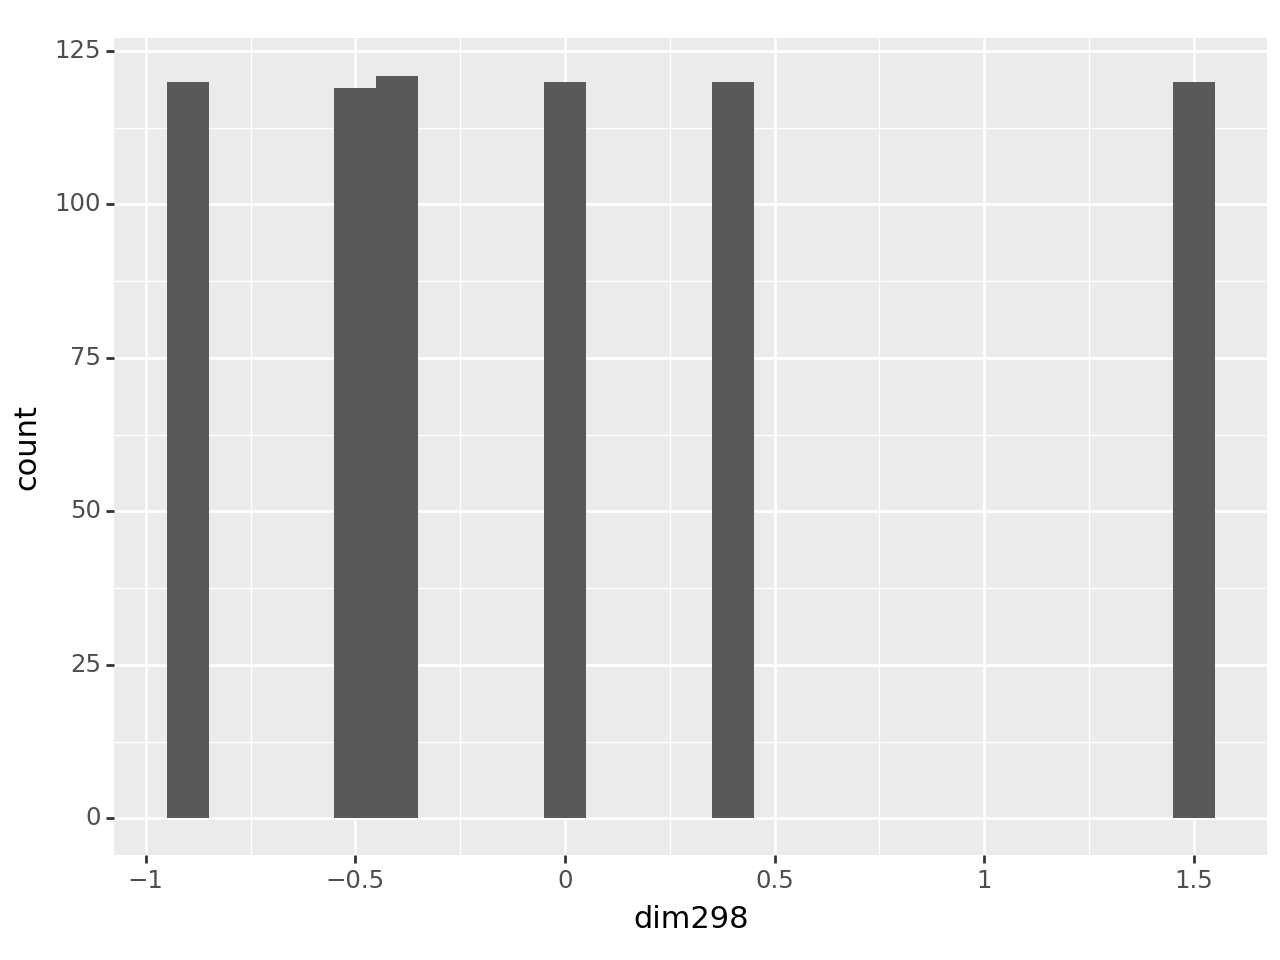

<Figure Size: (640 x 480)>

In [13]:
ggplot(left_preact_df, aes(x='dim298')) + geom_histogram(binwidth=0.1)

In [14]:
from functools import reduce

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, index, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': f'{sg_name}_{index}', f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)



def make_right_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


def make_left_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


In [15]:
no_really_all_s6_subgroups = {
    k: [generate_subgroup(g) for g in v['generators']] for k, v in all_s6_subgroups.items()
}

In [16]:
# You can calculate these yourself, but it takes a little time
#all_s6_right_coset_dfs = {k: make_right_full_coset_df(v, 6, k) for k, v in no_really_all_s6_subgroups.items()}
#all_s6_left_coset_dfs = {k: make_left_full_coset_df(v, 6, k) for k, v in no_really_all_s6_subgroups.items()}

all_s6_right_coset_dfs = pl.read_parquet('/mnt/ssd-1/dashiell/s6_right_cosets.parquet')
all_s6_left_coset_dfs = pl.read_parquet('/mnt/ssd-1/dashiell/s6_left_cosets.parquet')

In [17]:
lbase_df = left_preact_df.melt(id_vars='perms').rename({'perms': 'permutation'})
rbase_df = right_preact_df.melt(id_vars='perms').rename({'perms': 'permutation'})

In [18]:


def _analysis(df, coset_df):
    data = (
            df
            ##### Join against _all_ cosets, this is a many-to-1 join
            .join(coset_df, on='permutation', how='inner')
            .groupby(['variable', 'subgroup', 'coset_rep'])
            .agg([
                # Get the average value and variance of the (per dim) activations over a single coset
                # Small variance --> activations highly concentrated on the coset
                pl.col('value').var().alias('coset_var'),
                pl.col('value').mean().alias('coset_mean')
            ])
            .sort(['variable', 'subgroup', 'coset_rep'])
            .groupby(['variable', 'subgroup'], maintain_order=True)
            # Sum all the variances of the cosets for one subgroup
            .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
            # Sort ascending by coset variance
            #.sort(['variable', 'coset_cond_var'])
        
            #.groupby(['variable'], maintain_order=True)
            #.agg([
            #    # 
            #    pl.col('subgroup').first(),
            #    pl.col('coset_cond_var').first().alias('min_coset_var'),
            #    #(pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('sanity')
            #])
            #.sort('subgroup')
        )
    return data


def coset_analysis(df, coset_df_list):
    summary_df = (
        df
        .groupby(['variable'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    
    coset_data = pl.concat([_analysis(df, coset_df) for coset_df in coset_df_list], how='vertical')
    data = (
        coset_data
        .sort(['variable', 'coset_cond_var'])
        .groupby('variable', maintain_order=True)
        .head(5)
        
        #
        #
        #.agg(
        #    pl.col('subgroup').first(),
        #    pl.col('coset_cond_var').first().alias('min_coset_var'),
        #    (pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('min_vs_mean')
        #)
        .join(summary_df, on='variable')
        .with_columns(var_ratio=(pl.col('coset_cond_var') / pl.col('full_var')))
    )
    
    
    return data

In [19]:
# Again, you can calculate these yourself, but it takes a while (particularly on these nodes...)
# 
#left_perm_cosets = coset_analysis(lbase_df, all_s6_right_coset_dfs.values())
#right_perm_cosets = coset_analysis(rbase_df, all_s6_left_coset_dfs.values())
left_perm_cosets = pl.read_parquet('s6_50_0_left_perm_cosets.parquet')
right_perm_cosets = pl.read_parquet('s6_50_0_right_perm_cosets.parquet')

In [53]:
def transpose_power_df(data):
    irreps = data['irrep'].to_list()
    return (
        data
        .select(pl.exclude('irrep'))
        .transpose(
            include_header=True,
            header_name='variable', 
            column_names=irreps)
    )


transpose_power_df(lpower_df).filter(pl.col('variable') == 'dim222')

variable,"(1, 1, 1, 1, 1, 1)","(2, 1, 1, 1, 1)","(2, 2, 1, 1)","(2, 2, 2)","(3, 1, 1, 1)","(3, 2, 1)","(3, 3)","(4, 1, 1)","(4, 2)","(5, 1)","(6,)"
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""dim222""",1.7803e-7,0.00007,0.000036,0.000041,0.00001,0.000104,0.007251,0.000056,0.000061,0.991466,0.000906


In [31]:
(
    left_perm_cosets
    .sort(['variable', 'coset_cond_var'])
     .groupby('variable', maintain_order=True)
    .head(1)
    .join(transpose_power_df(lpower_df), on='variable')
    .groupby('subgroup')
    .agg(
        [
            pl.count(),
            pl.col('var_ratio').mean().alias('mean_var_ratio'),
           pl.col('two_norm').mean().alias('mean_two_norm'),
            pl.col('(5, 1)').mean(),

        ]
    )
    .filter(pl.col('(5, 1)') > .95)
    .sort('subgroup')
)

subgroup,count,mean_var_ratio,mean_two_norm,"(5, 1)"
str,u32,f32,f32,f32
"""A5_0""",2,0.237382,1155.71582,0.994712
"""A5_1""",13,0.680372,393.713684,0.953228
"""A5_2""",8,0.196094,536.294617,0.989357
"""A5_3""",6,0.784903,184.42041,0.990228
"""A5_4""",18,0.683703,624.842346,0.98008
"""A5_5""",10,0.114921,1088.227051,0.997128
"""C2_double_tran…",1,1.58466,173.612152,0.984851
"""C2_double_tran…",1,0.228488,1901.055176,0.995514
"""C2_double_tran…",1,1.143633,1425.512695,0.994639


In [50]:
(
    left_perm_cosets
    .sort(['variable', 'coset_cond_var'])
    .groupby('variable', maintain_order=True)
    .head(1)
    .filter(pl.col('subgroup').str.starts_with('S3xS3_'))
    .sort('var_ratio')
)

variable,subgroup,coset_cond_var,mean,min,max,full_var,two_norm,var_ratio
str,str,f32,f32,f32,f32,f32,f32,f32
"""dim31""","""S3xS3_six_cycl…",0.009921,0.000351,-2.543669,2.53668,4.02736,2895.672852,0.002464
"""dim640""","""S3xS3_six_cycl…",0.012349,-0.000986,-2.39981,2.382162,3.391745,2438.663818,0.003641
"""dim29""","""S3xS3_six_cycl…",0.012815,-0.002107,-2.335285,2.342775,3.418636,2458.001953,0.003749
"""dim141""","""S3xS3_six_cycl…",0.018916,0.000853,-2.878927,2.874045,4.966789,3571.121338,0.003808
"""dim634""","""S3xS3_six_cycl…",0.003388,0.000045,-1.190475,1.204113,0.847638,609.451294,0.003997
"""dim378""","""S3xS3_six_cycl…",0.011243,-0.000939,-2.19347,2.175603,2.789949,2005.973389,0.00403
"""dim695""","""S3xS3_six_cycl…",0.01227,-0.001763,-2.199824,2.212032,3.010234,2164.361572,0.004076
"""dim1014""","""S3xS3_six_cycl…",0.007233,0.001068,-1.709913,1.710957,1.708973,1228.751953,0.004233
"""dim79""","""S3xS3_six_cycl…",0.017512,-0.001845,-2.5663,2.578946,4.13363,2972.081299,0.004236


In [54]:
(
    left_perm_cosets
    .sort(['variable', 'coset_cond_var'])
    .groupby('variable', maintain_order=True)
    .head(1)
    #.filter(pl.col('subgroup').str.starts_with('S3xS3_'))
    .filter(pl.col('variable') == 'dim222')
    .sort('var_ratio')
)['subgroup'][0]

'S3xS3_six_cycles_three_cycle_8'

In [37]:
all_s6_right_coset_dfs.filter(pl.col('subgroup') == 'S4_four_cycle_transposition_double_transposition_6').head()

permutation,subgroup,coset_rep
str,str,str
"""(0, 1, 2, 5, 3…","""S4_four_cycle_…","""(0, 1, 2, 5, 3…"
"""(0, 1, 3, 2, 5…","""S4_four_cycle_…","""(0, 1, 2, 5, 3…"
"""(0, 1, 5, 3, 2…","""S4_four_cycle_…","""(0, 1, 2, 5, 3…"
"""(0, 4, 2, 3, 5…","""S4_four_cycle_…","""(0, 1, 2, 5, 3…"
"""(0, 4, 3, 5, 2…","""S4_four_cycle_…","""(0, 1, 2, 5, 3…"


In [43]:
S6_df = pl.DataFrame([{'permutation': str(p), 'parity': p.parity} for p in full_group])

In [44]:
S6_df.head()

permutation,parity
str,i64
"""(0, 1, 2, 3, 4…",0
"""(0, 1, 2, 4, 5…",0
"""(0, 1, 2, 5, 3…",0
"""(0, 1, 3, 2, 5…",0
"""(0, 1, 3, 4, 2…",0


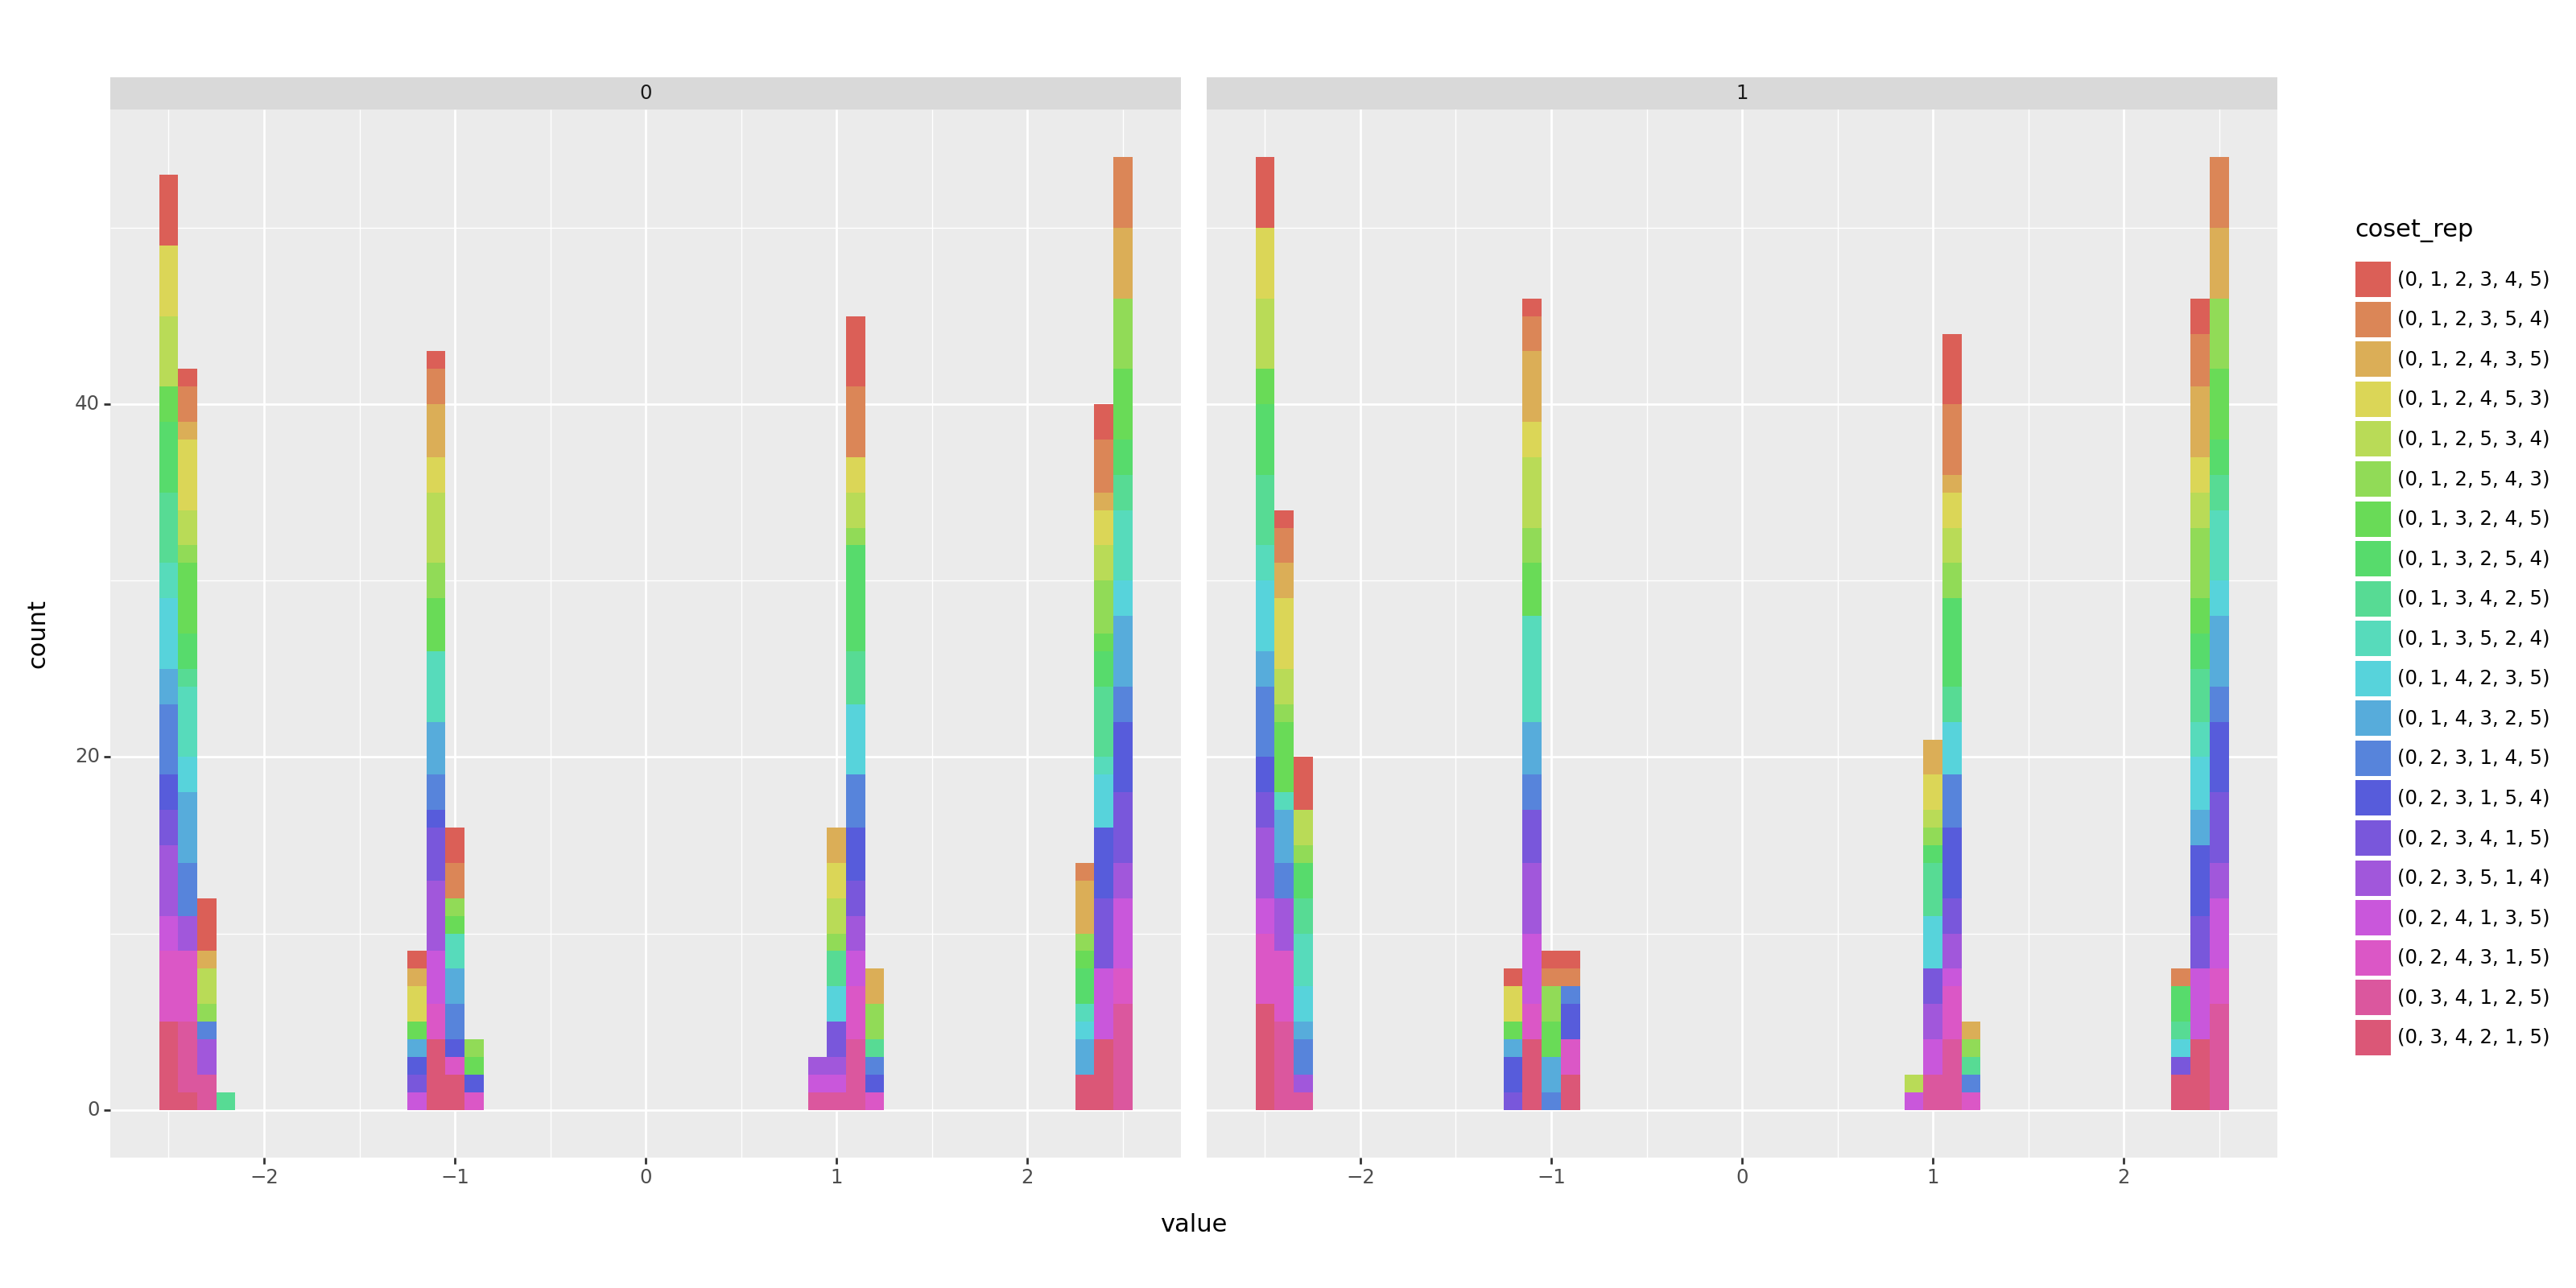

<Figure Size: (1600 x 800)>

In [56]:
df = (
    lbase_df
    .filter(pl.col('variable') == 'dim31')
    .join(
        all_s6_right_coset_dfs.filter(pl.col('subgroup') == 'S3xS3_six_cycles_three_cycle_8'),
        on='permutation' 
    )
    .join(S6_df, on = 'permutation')
)


ggplot(
    df,
    aes(x='value', fill='coset_rep')
) + geom_histogram(binwidth=0.1) + facet_wrap('~parity') +  theme(figure_size=(16, 8))


#lpower_df.melt(id_vars='irrep').filter((pl.col('irrep') == '(5, 1)') & (pl.col('value') > 0.9))

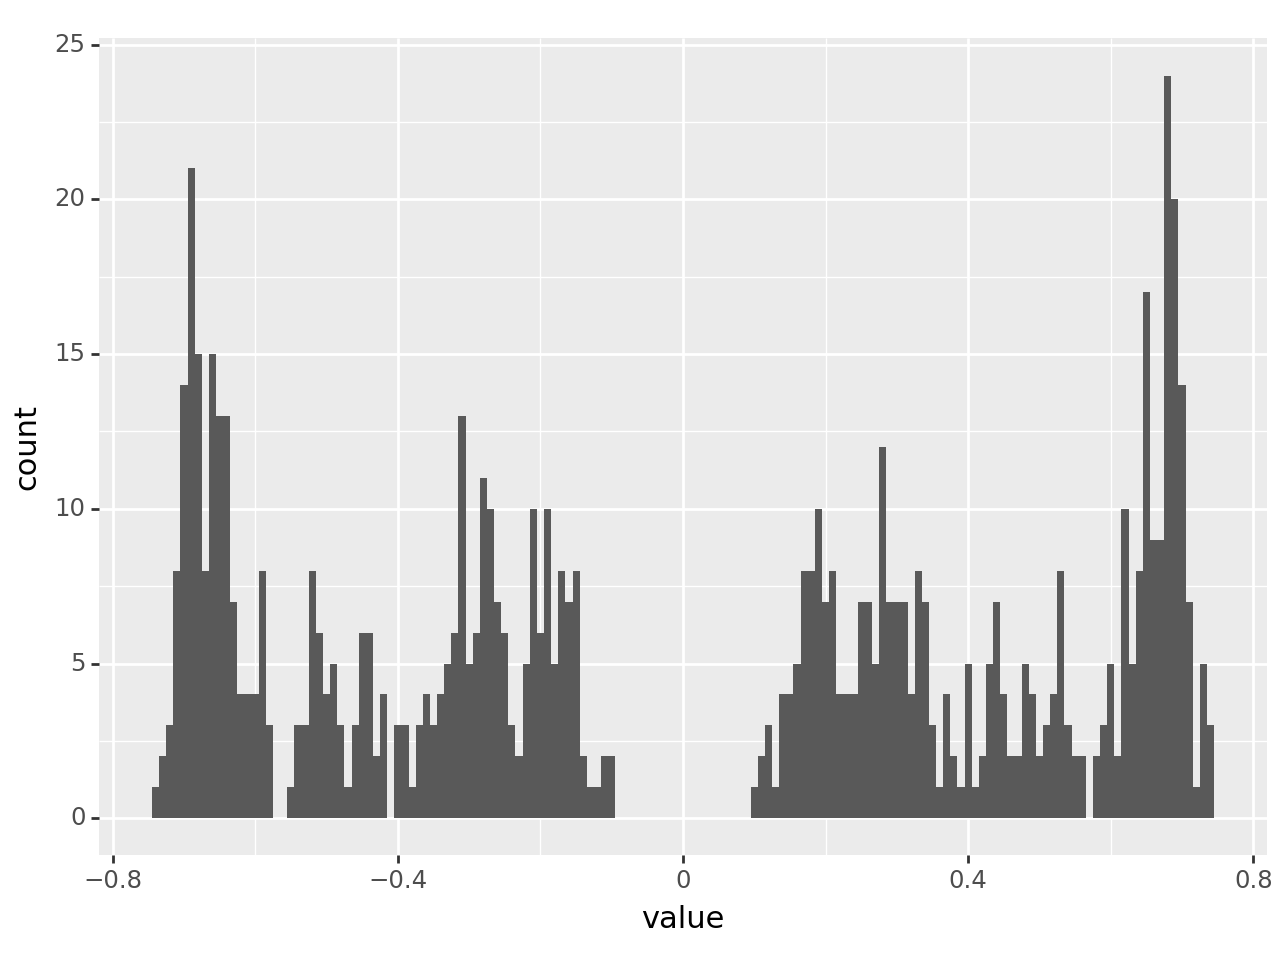

<Figure Size: (640 x 480)>

In [106]:
ggplot(lbase_df.filter(pl.col('variable') == 'dim5'), aes(x='value')) + geom_histogram(binwidth=0.01)

In [78]:
lp, rp, tp = [], [], []
for l, r in product(full_group, full_group):
    lp.append(str(l))
    rp.append(str(r))
    tp.append(str(l*r))
S6S6 = pl.DataFrame({'left_perm': lp, 'right_perm': rp, 'target_perm': tp})

In [81]:
preact_df = pl.concat([
    S6S6, pl.DataFrame(linear_preacts.detach().numpy(), schema=[f'dim{i}' for i in range(1024)])
], how='horizontal')

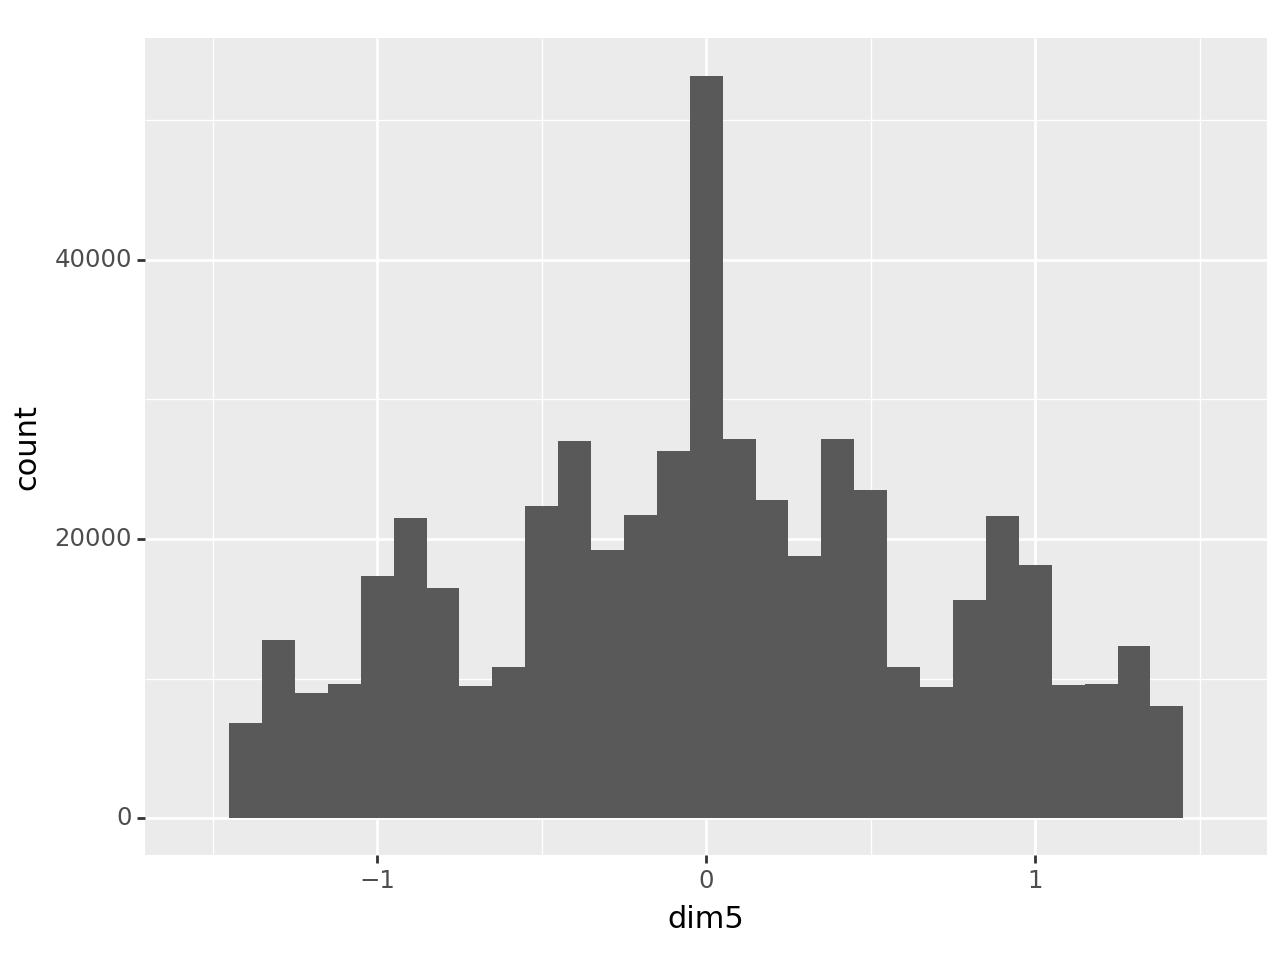

<Figure Size: (640 x 480)>

In [105]:
ggplot(preact_df, aes(x='dim5')) + geom_histogram(binwidth=0.1)

In [104]:
torch.dot(model.unembed.weight[:, 1012], model.unembed.weight[:, 1005])

tensor(-0.0374, grad_fn=<DotBackward0>)

In [118]:
dims3_3 = lpower_df.melt(id_vars='irrep').filter((pl.col('irrep') == "(3, 3)") & (pl.col('value') > 0.95))['variable'].to_list()

In [110]:
# 29, 227, 251, 55, 43, 68, 183
right_perm_cosets.filter(pl.col('variable') == 'dim5')

variable,subgroup,coset_cond_var,mean,min,max,full_var,two_norm,var_ratio
str,str,f32,f32,f32,f32,f32,f32,f32
"""dim5""","""A6_0""",0.045204,-0.007803,-0.430274,0.460972,0.022585,16.28224,2.001534
"""dim5""","""S5_exceptional…",0.09579,-0.007803,-0.430274,0.460972,0.022585,16.28224,4.241378
"""dim5""","""S5_exceptional…",0.105513,-0.007803,-0.430274,0.460972,0.022585,16.28224,4.671867
"""dim5""","""S5_exceptional…",0.121193,-0.007803,-0.430274,0.460972,0.022585,16.28224,5.366153
"""dim5""","""S5_exceptional…",0.12372,-0.007803,-0.430274,0.460972,0.022585,16.28224,5.478059


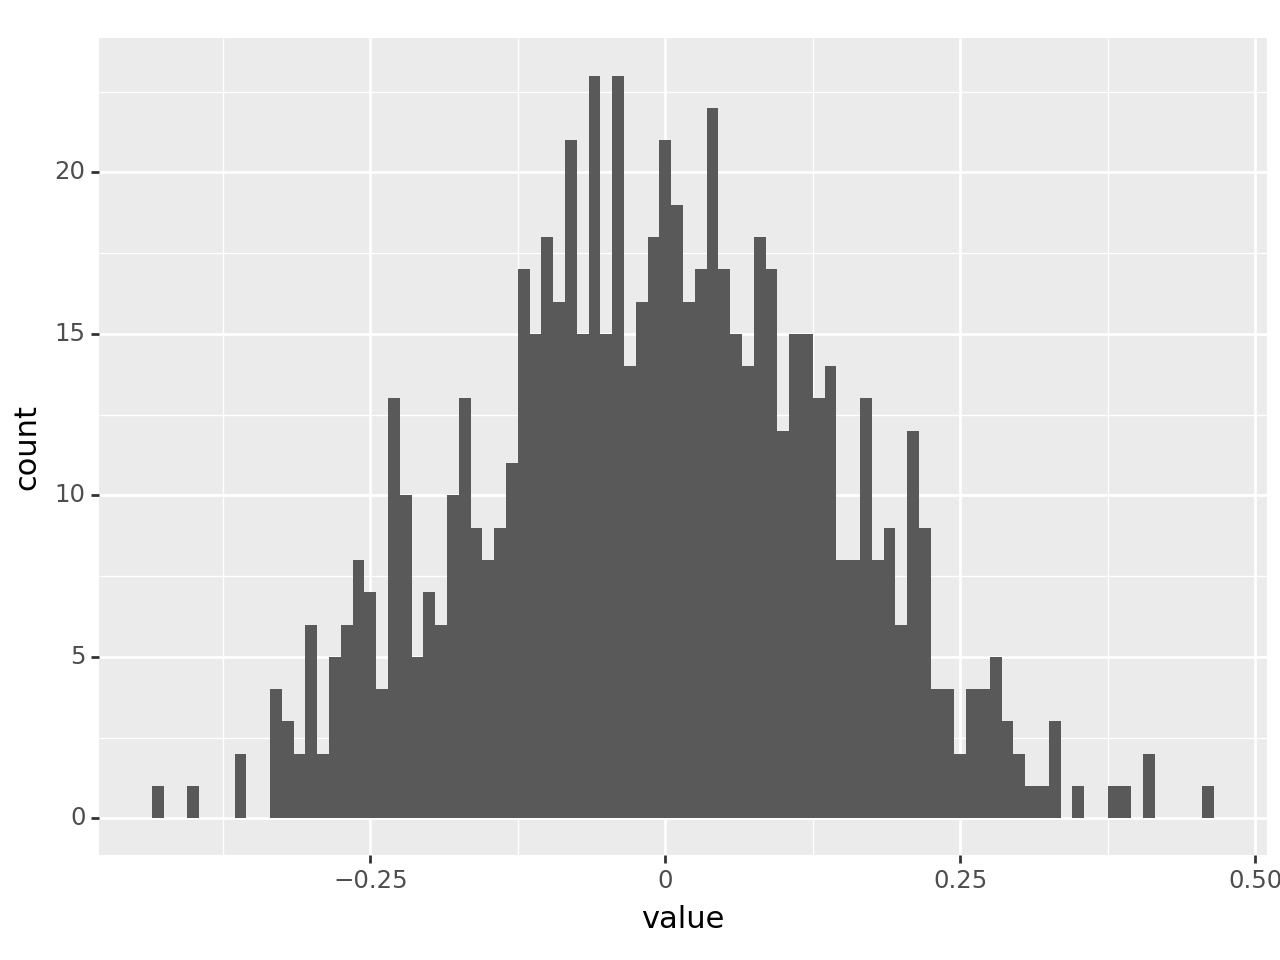

<Figure Size: (640 x 480)>

In [112]:
ggplot(rbase_df.filter(pl.col('variable') == 'dim5'), aes(x='value')) + geom_histogram(binwidth=0.01)

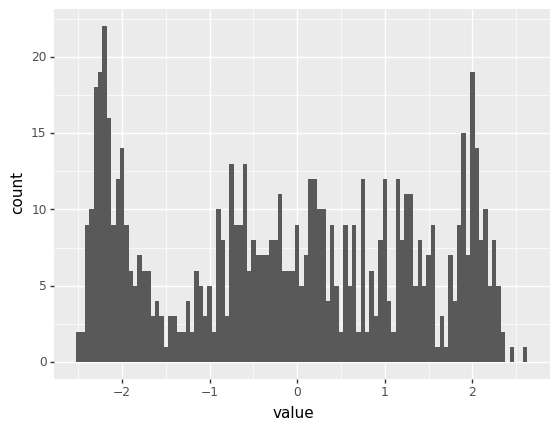

<ggplot: (711918412)>

In [139]:
ggplot(rbase_df.filter(pl.col('variable') == dim), aes(x='value')) + geom_histogram(binwidth=0.05)

In [114]:
right_perm_cosets.filter(pl.col('variable') == 'dim251')

variable,subgroup,coset_cond_var,mean,min,max,full_var,two_norm,var_ratio
str,str,f32,f32,f32,f32,f32,f32,f32
"""dim251""","""A6_0""",3.039003,-0.061759,-3.144857,2.399359,1.521292,1096.554688,1.997646
"""dim251""","""S5_exceptional…",4.384474,-0.061759,-3.144857,2.399359,1.521292,1096.554688,2.882072
"""dim251""","""S5_exceptional…",5.662667,-0.061759,-3.144857,2.399359,1.521292,1096.554688,3.722274
"""dim251""","""S5_exceptional…",7.709663,-0.061759,-3.144857,2.399359,1.521292,1096.554688,5.067838
"""dim251""","""C2xS4_3""",8.096655,-0.061759,-3.144857,2.399359,1.521292,1096.554688,5.322222


In [72]:
(
    left_perm_cosets
    .with_columns(var_ratio = pl.col('min_coset_var') / pl.col('full_var'))
    .groupby('subgroup')
    .agg(
        pl.count(),
        pl.col('var_ratio').mean(),
        pl.col('var_ratio').median().alias('median_var_ratio'),
        pl.col('min_coset_var').mean()
    )
    .sort('var_ratio')
)

subgroup,count,var_ratio,median_var_ratio,min_coset_var
str,u32,f32,f32,f32
"""S5_exceptional…",16,9.1028e-7,1.3353e-7,0.000004
"""S5_1""",25,0.000011,0.000007,0.000147
"""S5_0""",21,0.000042,0.000023,0.000511
"""S5_3""",15,0.000098,0.000013,0.001302
"""S4_5""",1,0.000432,0.000432,0.00808
"""S5_exceptional…",3,0.001978,0.001896,0.005865
"""S5_4""",14,0.003521,0.000023,0.011733
"""S5_2""",17,0.007403,0.000006,0.040176
"""S5_exceptional…",5,0.035902,0.000391,0.0012


In [78]:
# 29, 227, 251, 55, 43, 68, 183
(
    left_perm_cosets
    .with_columns(var_ratio = pl.col('min_coset_var') / pl.col('full_var'))
    .filter(pl.col('subgroup') == 'A6_0').sort('var_ratio')
)

variable,subgroup,min_coset_var,sanity,mean,min,max,full_var,two_norm,var_ratio
str,str,f32,f32,f32,f32,f32,f32,f32,f32
"""dim18""","""A6_0""",0.000351,797.774597,0.000098,-3.005281,3.006968,9.024618,6488.697266,0.000039
"""dim22""","""A6_0""",0.000338,766.192139,0.000096,-2.94522,2.946844,8.667364,6231.828613,0.000039
"""dim75""","""A6_0""",0.000334,758.702393,-0.000094,-2.932453,2.930715,8.582624,6170.906738,0.000039
"""dim15""","""A6_0""",0.000318,720.975891,-0.000091,-2.858599,2.856929,8.155807,5864.022949,0.000039
"""dim50""","""A6_0""",0.00032,726.972839,0.000093,-2.868865,2.870417,8.223696,5912.84082,0.000039
"""dim135""","""A6_0""",0.000501,1136.739258,-0.000123,-3.589503,3.587359,12.859048,9245.65625,0.000039
"""dim124""","""A6_0""",0.000496,1124.433838,-0.000122,-3.570031,3.567908,12.719912,9145.623047,0.000039
"""dim153""","""A6_0""",0.000649,1470.250244,0.000148,-4.079603,4.082704,16.631788,11958.254883,0.000039
"""dim137""","""A6_0""",1.253101,72.188248,0.006527,-1.12694,1.161739,0.66661,479.322968,1.879813


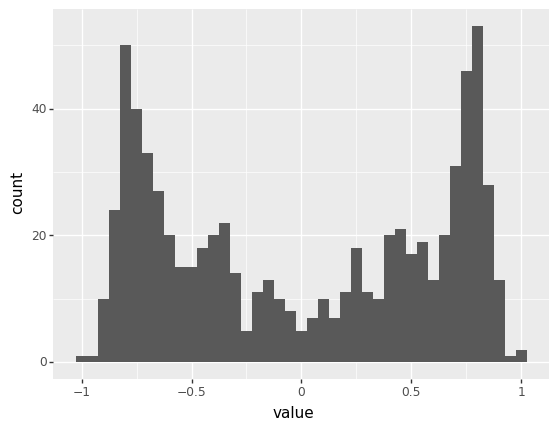

<ggplot: (691546929)>

In [99]:
ggplot(base_df.filter(pl.col('variable') == 'dim227'), aes(x='value')) + geom_histogram(binwidth=0.05)

In [83]:
lpower_df.select(['irrep', 'dim251'])

irrep,dim251
str,f32
"""(1, 1, 1, 1, 1…",0.002504
"""(2, 1, 1, 1, 1…",0.002293
"""(2, 2, 1, 1)""",0.003213
"""(2, 2, 2)""",0.000381
"""(3, 1, 1, 1)""",0.000302
"""(3, 2, 1)""",0.001272
"""(3, 3)""",0.978312
"""(4, 1, 1)""",0.001289
"""(4, 2)""",0.000324
